### Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

Сдача проекта:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

### Описание датасета

    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

In [302]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams.update({'font.size': 14})

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [299]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print('Train R2:' + str(round(r2(train_true_values, train_pred_values), 3)))
    print('Test R2:' + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.show()

In [429]:
DATASET_TRAIN_PATH = 'datasets/train.csv'
DATASET_PREPARED_TRAIN_PATH = 'datasets/train_prepared.csv'

DATASET_TEST_PATH = 'datasets/test.csv'
DATASET_PREPARED_TEST_PATH = 'datasets/test_prepared.csv'

DATASET_ANSWERED_PATH = 'datasets/EChebotarev_predictions.csv'

In [244]:
train_df = pd.read_csv(DATASET_TRAIN_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [306]:
test_df = pd.read_csv(DATASET_TEST_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [245]:
train_df.shape

(10000, 20)

In [246]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [247]:
train_df['Id'] = train_df['Id'].astype('str')
train_df['Id'].dtype

dtype('O')

In [307]:
test_df['Id'] = test_df['Id'].astype('str')
test_df['Id'].dtype

dtype('O')

### Обзор числовых признаков

In [248]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
train_df_num_features.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


In [249]:
train_df_num_features.shape

(10000, 16)

In [250]:
train_df_num_features.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обзор номинативных признаков

In [251]:
train_df_obj_features = train_df.select_dtypes(include=['object'])
train_df_obj_features.head()

,Id,Ecology_2,Ecology_3,Shops_2
0,14038,B,B,B
1,15053,B,B,B
2,4765,B,B,B
3,5809,B,B,B
4,10783,B,B,B


In [252]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [253]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [254]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка пропусков

In [255]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

 **LifeSquare**

In [256]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()

In [309]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = test_df['LifeSquare'].median()

**Healthcare_1**

In [257]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [310]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

In [258]:
len(train_df) - train_df.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

### Обработка выбросов

In [259]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Rooms**

In [260]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [261]:
train_df.loc[train_df['Rooms'].isin([0, 6, 10, 19]), 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

In [312]:
test_df.loc[test_df['Rooms'].isin([0, 6, 10, 19, 17]), 'Rooms'] = test_df['Rooms'].median()
test_df['Rooms'].value_counts()

2.0    2035
1.0    1769
3.0    1099
4.0      90
5.0       7
Name: Rooms, dtype: int64

**Square, LifeSquare, KitchenSquare**

In [262]:
# Square

train_df.loc[
    (train_df['Square'] > train_df['Square'].quantile(.975)) |
    (train_df['Square'] < train_df['Square'].quantile(.025))
    ,'Square'
] = train_df['Square'].median()

In [313]:
# Square

test_df.loc[
    (test_df['Square'] > test_df['Square'].quantile(.975)) |
    (test_df['Square'] < test_df['Square'].quantile(.025))
    ,'Square'
] = test_df['Square'].median()

In [263]:
# LifeSquare

train_df.loc[
    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.975)) |
    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.025))
    ,'LifeSquare'
] = train_df['LifeSquare'].median()

In [314]:
# LifeSquare

test_df.loc[
    (test_df['LifeSquare'] > test_df['LifeSquare'].quantile(.975)) |
    (test_df['LifeSquare'] < test_df['LifeSquare'].quantile(.025))
    ,'LifeSquare'
] = test_df['LifeSquare'].median()

In [264]:
# KitchenSquare

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
train_df.loc[
    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.98)), 
    'KitchenSquare'
] = train_df['KitchenSquare'].median()

In [315]:
# KitchenSquare

test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
test_df.loc[
    (test_df['KitchenSquare'] > test_df['KitchenSquare'].quantile(.98)), 
    'KitchenSquare'
] = test_df['KitchenSquare'].median()

In [265]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.888400,55.108599,34.534440,6.238200,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.587592,0.811056,15.215053,11.451088,2.794717,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.000000,1.000000,32.105270,15.146290,3.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,42.432730,27.982505,3.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,64.591720,39.424685,8.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,5.000000,100.904263,78.384631,13.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Floor, HouseFloor**

In [266]:
# HouseFloor

train_df.loc[
    (train_df['HouseFloor'] == 0) |
    (train_df['HouseFloor'] > 25),
    'HouseFloor'
] = train_df['HouseFloor'].median()

train_df['HouseFloor'].describe()

count    10000.000000
mean        12.815400
std          6.030154
min          1.000000
25%          9.000000
50%         13.000000
75%         17.000000
max         25.000000
Name: HouseFloor, dtype: float64

In [317]:
# HouseFloor

test_df.loc[
    (test_df['HouseFloor'] == 0) |
    (test_df['HouseFloor'] > 25),
    'HouseFloor'
] = test_df['HouseFloor'].median()

test_df['HouseFloor'].describe()

count    5000.000000
mean       12.726000
std         6.042369
min         1.000000
25%         9.000000
50%        12.000000
75%        17.000000
max        25.000000
Name: HouseFloor, dtype: float64

In [267]:
# Floor

floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

train_df.loc[floor_outliers, 'Floor'].describe()


count    1642.000000
mean        4.261876
std         4.224460
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        24.000000
Name: Floor, dtype: float64

In [318]:
# Floor

test_floor_outliers = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index
test_df.loc[test_floor_outliers, 'Floor'] = test_df.loc[test_floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

test_df.loc[test_floor_outliers, 'Floor'].describe()


count    818.000000
mean       4.612469
std        4.429808
min        1.000000
25%        1.000000
50%        3.000000
75%        7.000000
max       23.000000
Name: Floor, dtype: float64

**HouseYear**

In [268]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [319]:
test_df.loc[test_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [269]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.888400,55.108599,34.534440,6.238200,7.345200,12.815400,1984.872400,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.587592,0.811056,15.215053,11.451088,2.794717,4.953008,6.030154,18.416347,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.000000,1.000000,32.105270,15.146290,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,42.432730,27.982505,3.000000,3.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,6.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,64.591720,39.424685,8.000000,10.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,5.000000,100.904263,78.384631,13.000000,25.000000,25.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [273]:
train_df['Ecology_2_dummies'] = train_df['Ecology_2'].replace({'A': 0, 'B': 1})
train_df['Ecology_3_dummies'] = train_df['Ecology_3'].replace({'A': 0, 'B': 1})
train_df['Shops_2_dummies'] = train_df['Shops_2'].replace({'A': 0, 'B': 1})

In [320]:
test_df['Ecology_2_dummies'] = test_df['Ecology_2'].replace({'A': 0, 'B': 1})
test_df['Ecology_3_dummies'] = test_df['Ecology_3'].replace({'A': 0, 'B': 1})
test_df['Shops_2_dummies'] = test_df['Shops_2'].replace({'A': 0, 'B': 1})

### Отбор признаков

In [277]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_dummies',
 'Ecology_3_dummies',
 'Shops_2_dummies']

In [286]:
feature_names = [
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1'
]
new_feature_names = ['Ecology_2_dummies',  'Ecology_3_dummies', 'Shops_2_dummies']
target_name = 'Price'

 ### Разбиение на train и test

In [287]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [322]:
X_validate = test_df[feature_names + new_feature_names]

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

### Построение модели

In [417]:
rf_model = RandomForestRegressor(
    random_state=42, 
    n_estimators=1000, 
    max_features=6,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [418]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

### Предсказание целевой переменной на валидационной выборке

In [419]:
y_validate_preds = rf_model.predict(X_validate)

In [420]:
y_validate_preds

array([161183.61941804, 227559.000905  , 269363.51557386, ...,
       324411.36014239, 193590.91073425, 187783.09469815])

In [432]:
answer = pd.concat([test_df['Id'], pd.DataFrame({'Price': y_validate_preds})], axis=1)

In [433]:
answer.shape

(5000, 2)

In [434]:
answer.to_csv(path_or_buf=DATASET_ANSWERED_PATH, index=False)

Train R2:0.963
Test R2:0.72


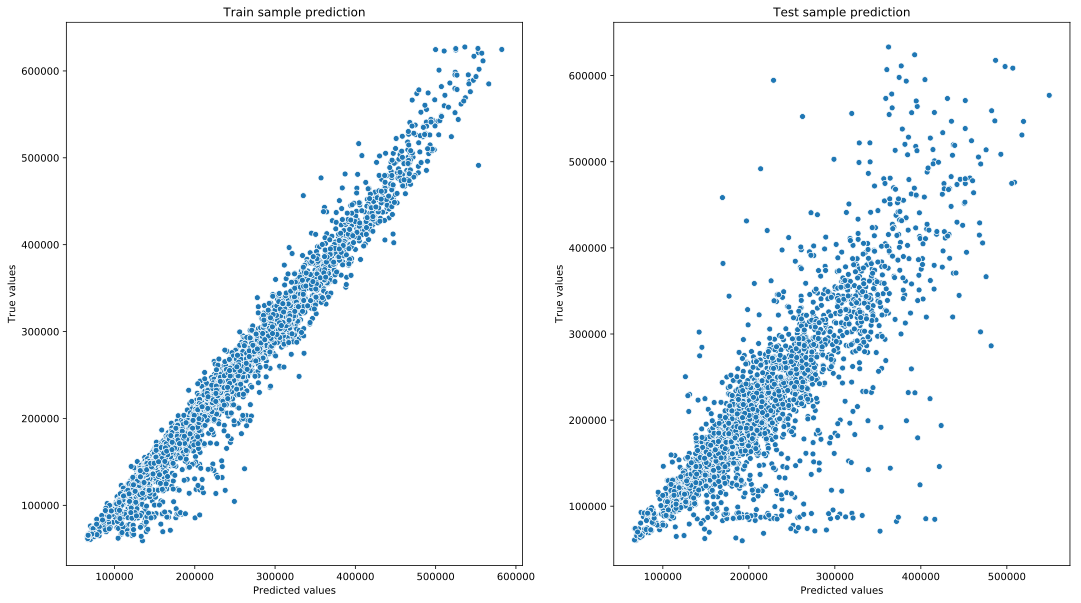

In [423]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Перекрестная валидация

In [424]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=10, shuffle=True, random_state=42))
cv_score

array([0.70956546, 0.7441237 , 0.72795839, 0.72505517, 0.74579184,
       0.73982946, 0.70865849, 0.74055683, 0.79962543, 0.74014022])